In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from MODULES.encoders_decoders import *
import torch

In [3]:
from MODULES.vae_model import *
from MODULES.utilities_ml import process_one_epoch
from MODULES.utilities_visualization import show_batch
import torch.nn.functional as F
from MODULES.utilities_ml import ConditionalRandomCrop, SpecialDataSet, process_one_epoch


# Check versions
from platform import python_version
print("python_version() ---> ", python_version())
print("torch.__version__ --> ", torch.__version__)

python_version() --->  3.8.2
torch.__version__ -->  1.6.0


In [4]:
multi_mnist_data_train = "/Users/ldalessi/DAPI_unsupervised/spacetx-research/dataset_multiMNIST/multi_mnist_train.pt"
multi_mnist_data_test = "/Users/ldalessi/DAPI_unsupervised/spacetx-research/dataset_multiMNIST/multi_mnist_test.pt"

params = load_json_as_dict("./ML_parameters.json")
img_train, seg_mask_train, count_train  = load_obj(multi_mnist_data_train)
img_test, seg_mask_test, count_test  = load_obj(multi_mnist_data_test)

BATCH_SIZE = params["simulation"]["batch_size"]
SIZE_CROPS = params["input_image"]["size_raw_image"]
N_TEST = params["simulation"]["N_test"]
N_TRAIN = params["simulation"]["N_train"]

train_loader = SpecialDataSet(img=img_train, 
                              roi_mask=None, 
                              seg_mask=seg_mask_train, 
                              labels=count_train, 
                              batch_size=4, #BATCH_SIZE , 
                              drop_last=False,
                              shuffle=True)

test_loader = SpecialDataSet(img=img_test, 
                             roi_mask=None, 
                             seg_mask=seg_mask_test, 
                             labels=count_test, 
                             batch_size=4, #BATCH_SIZE , 
                             drop_last=False,
                             shuffle=False)

test_batch_example_fig = test_loader.check_batch()
train_batch_example_fig = train_loader.check_batch()

Dataset lenght: 500
img.shape torch.Size([500, 1, 80, 80])
img.dtype torch.float32
img.device cpu
MINIBATCH: img.shapes seg.shape labels.shape, index.shape -> torch.Size([8, 1, 80, 80]) torch.Size([8, 1, 80, 80]) torch.Size([8]) torch.Size([8])
MINIBATCH: min and max of minibatch tensor(0.) tensor(0.9992)
Dataset lenght: 5000
img.shape torch.Size([5000, 1, 80, 80])
img.dtype torch.float32
img.device cpu
MINIBATCH: img.shapes seg.shape labels.shape, index.shape -> torch.Size([8, 1, 80, 80]) torch.Size([8, 1, 80, 80]) torch.Size([8]) torch.Size([8])
MINIBATCH: min and max of minibatch tensor(0.) tensor(1.)


In [33]:
params

{'neptune_project': 'dalessioluca/MNIST',
 'simulation': {'__comment': 'there are 3 types of runs: scratch, resume, pretrained',
  'type': 'scratch',
  'MAX_EPOCHS': 501,
  'TEST_FREQUENCY': 10,
  'CHECKPOINT_FREQUENCY': 50,
  'batch_size': 128,
  'N_test': 128,
  'N_train': 512},
 'architecture': {'__comment': 'architecture parameters, level_zwhere_output is between 0 and n_max_pool included',
  'dim_zinstance': 5,
  'dim_zwhere': 4,
  'dim_zbg': 4,
  'dim_logit': 1,
  'cropped_size': 28,
  'n_max_pool': 4,
  'level_zwhere_and_logit_output': 2,
  'level_background_output': 4,
  'n_ch_output_features': 32,
  'n_ch_after_first_two_conv': 32,
  'concatenate_raw_image_to_fmap': False},
 'DPP': {'__comment': 'parameters for the DPP prior', 'n_kernels': 1},
 'input_image': {'__comment': 'parameters describing the input images',
  'n_objects_max': 10,
  'size_object_min': 15,
  'size_object_max': 50,
  'length_scale_similarity': 10.0,
  'size_raw_image': 80,
  'ch_in': 1},
 'nms': {'__commen

[0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101  0.11111111
 0.12121212 0.13131313 0.14141414 0.15151515 0.16161616 0.17171717
 0.18181818 0.19191919 0.2020202  0.21212121 0.22222222 0.23232323
 0.24242424 0.25252525 0.26262626 0.27272727 0.28282828 0.29292929
 0.3030303  0.31313131 0.32323232 0.33333333 0.34343434 0.35353535
 0.36363636 0.37373737 0.38383838 0.39393939 0.4040404  0.41414141
 0.42424242 0.43434343 0.44444444 0.45454545 0.46464646 0.47474747
 0.48484848 0.49494949 0.50505051 0.51515152 0.52525253 0.53535354
 0.54545455 0.55555556 0.56565657 0.57575758 0.58585859 0.5959596
 0.60606061 0.61616162 0.62626263 0.63636364 0.64646465 0.65656566
 0.66666667 0.67676768 0.68686869 0.6969697  0.70707071 0.71717172
 0.72727273 0.73737374 0.74747475 0.75757576 0.76767677 0.77777778
 0.78787879 0.7979798  0.80808081 0.81818182 0.82828283 0.83838384
 0.84848485 0.85858586 0.86868687 0.87878788 0.88888889 0.89898

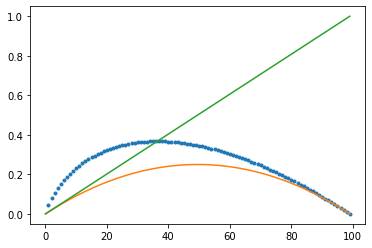

In [8]:
x = numpy.linspace(0,1,100)
plt.plot(-x*numpy.log(x),'.')
plt.plot(x*(1-x))
plt.plot(x)
print(x)

In [26]:
vae = CompositionalVae(params)
vae.prob_corr_factor = 0.5
optimizer = instantiate_optimizer(model=vae, dict_params_optimizer=params["optimizer"])

In [35]:
for epoch in range(1):
    train_metrics = process_one_epoch(model=vae, 
                                      dataloader=test_loader, 
                                      optimizer=optimizer, 
                                      verbose=(epoch == 0),
                                      weight_clipper=None)

i =   0 train_loss=17.91641
i =   1 train_loss=16.80751
i =   2 train_loss=17.95709


KeyboardInterrupt: 

In [28]:
imgs_in = test_loader.load(8)[0]
show_batch(imgs_in)

out = vae.forward(imgs_in)

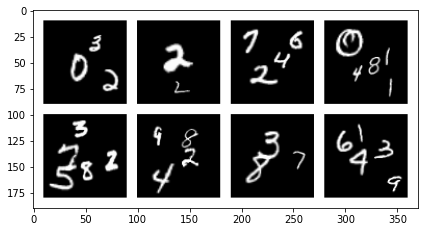

In [34]:
show_batch(imgs_in)

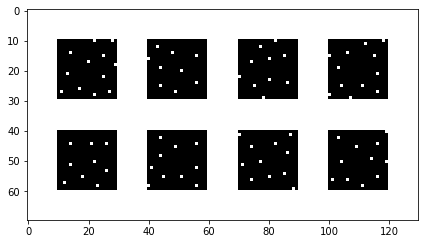

In [32]:
show_batch(out.inference.sample_c_map)

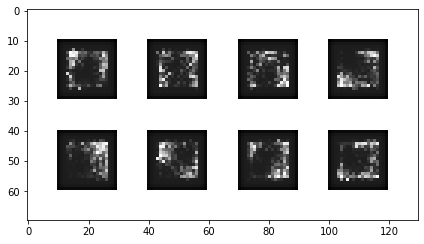

In [29]:
show_batch(out.inference.prob_map)

In [30]:
out.inference.kl_logit

tensor([-425.2641, -436.1841, -432.1406, -426.0144, -436.0650, -433.1842,
        -429.5867, -429.5433], grad_fn=<SubBackward0>)

In [ ]:
img_to_segment = train_loader.img[0, :, 1060:1360, 2100:2400]
plt.imshow(img_to_segment[0])

In [ ]:
ix = 1240-160
iy= 2140
print(ix)
img_to_segment = train_loader.img[0, :, ix:ix+2*(80), iy:iy+4*(80)]
plt.imshow(img_to_segment[0])

In [ ]:

img_to_segment = train_loader.img[0, :, 940:1240, 2140:2440]
plt.imshow(img_to_segment[0])

In [ ]:
Entropy(\pi)

In [ ]:
# params

In [ ]:
image_size = params['input_image']['size_raw_image']
b, c, w, h = 8, params['input_image']['ch_in'], image_size, image_size
imgs_in = torch.sigmoid(torch.randn(b,c,w, h))



In [ ]:
show_batch(imgs_in)

In [ ]:
#from MODULES.utilities_ml import SpecialDataSet
#
#train_loader = SpecialDataSet(img=imgs_in,
#                              store_in_cuda=False,
#                              shuffle=True,
#                              drop_last=True,
#                              batch_size=2)
#optimizer = instantiate_optimizer(model=vae, dict_params_optimizer=params["optimizer"])
#epoch_restart = -1
#history_dict = {}
#min_test_loss = 99999999
#    
#for delta_epoch in range(1, 5):
#    epoch = delta_epoch+epoch_restart
#    with torch.autograd.set_detect_anomaly(True):
#        train_metrics = process_one_epoch(model=vae, 
#                                          dataloader=train_loader, 
#                                          optimizer=optimizer, 
#                                          verbose=True)
#        print(train_metrics.pretty_print(epoch))

In [ ]:
vae.inference_and_generator.similarity_kernel_dpp.get_l_w()

In [ ]:
print(generated._fields)
print(generated.inference._fields)
print(generated.inference.sample_c_map.shape)
show_batch(generated.inference.sample_c_map.float())

In [ ]:
#generated.inference.prob_map[0,0]

In [ ]:
show_batch(generated.inference.prob_map)

In [ ]:
from MODULES.utilities_visualization import plot_reconstruction_and_inference, plot_segmentation

plot_reconstruction_and_inference(generated, epoch=0, prefix="gen_")

In [ ]:
vae.prob_corr_factor = 0.0
output = vae.forward(imgs_in, draw_image=True, draw_boxes=True, verbose=False)

In [ ]:
print(torch.max(output.inference.prob_map))
show_batch(output.inference.prob_map)

In [ ]:
c_map_2 = (torch.rand_like(output.inference.prob_map) < output.inference.prob_map).float()
show_batch(c_map_2)

In [ ]:
show_batch(output.inference.sample_c_map)

In [ ]:
show_batch(output.inference.sample_c_map)

In [ ]:
print(output.inference.bb_few.bh[..., 0])
print(vae.inference_and_generator.size_min)
print(vae.inference_and_generator.size_max)

In [ ]:
plot_reconstruction_and_inference(output, epoch=0, prefix="rec_")

In [ ]:
vae